In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel("E:\\Projects\\Building Managment\\edited.xlsx")

In [3]:
df.head()

,Month,Cost,Amount,Date,Units involve
0,Farvardin 403,Cleaning,300000,1403/01/13,All
1,Farvardin 403,Elevator keeping,450000,1403/1/25,"But 1,3"
2,Farvardin 403,Water Pump Welding,1000000,1403/1/28,All
3,Farvardin 403,Public Restroom Maintenance,150000,1403/1/27,All
4,Ordibehesht 403,Cleaning,400000,1403/02/02,All


In [4]:
df = df.dropna()

In [5]:
# Clean amount: remove comma, convert to int
df["Amount"] = df["Amount"].astype(str).str.replace(",", "").astype(int)

C:\Users\Yasaman\AppData\Local\Temp\ipykernel_17104\3173605587.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Amount"] = df["Amount"].astype(str).str.replace(",", "").astype(int)


In [8]:
df['Amount'].head()

0     300000
1     450000
2    1000000
3     150000
4     400000
Name: Amount, dtype: int64

In [9]:
# Normalize cost names
df["Cost"] = (
    df["Cost"]
    .astype(str)
    .str.strip()
    .str.title()
    .replace({
        "Electriciy Bill": "Electricity Bill",
        "Water Bill": "Water Bill",
        "Buying Faucet And Water Hose": "Buying Faucet And Hose"
    })
)


In [10]:
# Clean 'Units involve'
df["Units involve"] = df["Units involve"].str.strip()

In [14]:
# تابع محاسبه سهم‌ها
def calculate_shares(units_involve, amount):
    if units_involve.lower() == "all":
        share_all = round(amount / 11)
        return share_all, share_all
    elif "but 1,3" in units_involve.lower():
        share_except = round(amount / 9)
        return share_except, 0
    else:
        return 0, 0

# افزودن دو ستون جدید
df["Unit 1&3 Share"] = 0
df["Other Units Share"] = 0

# محاسبه سهم‌ها
for idx, row in df.iterrows():
    other_share, one_three_share = calculate_shares(row["Units involve"], row["Amount"])
    df.at[idx, "Other Units Share"] = other_share
    df.at[idx, "Unit 1&3 Share"] = one_three_share


In [15]:
df.head()

,Month,Cost,Amount,Date,Units involve,Unit 1&3 Share,Other Units Share
0,Farvardin 403,Cleaning,300000,1403/01/13,All,27273,27273
1,Farvardin 403,Elevator Keeping,450000,1403/1/25,"But 1,3",0,50000
2,Farvardin 403,Water Pump Welding,1000000,1403/1/28,All,90909,90909
3,Farvardin 403,Public Restroom Maintenance,150000,1403/1/27,All,13636,13636
4,Ordibehesht 403,Cleaning,400000,1403/02/02,All,36364,36364


In [16]:
# Mapping Costs
cost_mapping = {
    "Buying 8 Lamps": "Lighting",
    "Buying Glue": "Lighting",
    "Buying Faucet And Hose": "Plumbing",
    "Drain Unclogging": "Plumbing",
    "Naylon For Restroom": "Plumbing",
    "Cleaning": "Cleaning",
    "Electricity Bill": "Utilities",
    "Water Bill": "Utilities",
    "Elevator Keeping": "Elevator Maintenance",
    "Elevator Oil": "Elevator Maintenance",
    "Flutter Replacement": "Repairs",
    "Intercom System Repair": "Repairs",
    "Pump Repair": "Repairs",
    "Water Pump Welding": "Repairs",
    "Public Restroom Maintenance": "Public Facilities"
}

df["Cost Category"] = df["Cost"].map(cost_mapping)


In [17]:
df.head()

,Month,Cost,Amount,Date,Units involve,Unit 1&3 Share,Other Units Share,Cost Category
0,Farvardin 403,Cleaning,300000,1403/01/13,All,27273,27273,Cleaning
1,Farvardin 403,Elevator Keeping,450000,1403/1/25,"But 1,3",0,50000,Elevator Maintenance
2,Farvardin 403,Water Pump Welding,1000000,1403/1/28,All,90909,90909,Repairs
3,Farvardin 403,Public Restroom Maintenance,150000,1403/1/27,All,13636,13636,Public Facilities
4,Ordibehesht 403,Cleaning,400000,1403/02/02,All,36364,36364,Cleaning


In [24]:
# sum of payment by each unit
unit_totals = {
    "Unit 1": df["Unit 1&3 Share"].sum(),
    "Unit 3": df["Unit 1&3 Share"].sum()
}
for u in [2, 4, 5, 6, 7, 8, 9, 10, 11]:
    unit_totals[f"Unit {u}"] = df["Other Units Share"].sum()
unit_totals_df = pd.DataFrame(list(unit_totals.items()), columns=["Unit", "Total Paid (Toman)"])


In [26]:
# costs per category 
category_summary = df.groupby("Cost Category")["Amount"].agg(["sum", "count"]).reset_index()
category_summary.columns = ["Category", "Total Amount (Toman)", "Occurrences"]


In [27]:
# most and least costs
max_row = df.loc[df["Amount"].idxmax()]
min_row = df.loc[df["Amount"].idxmin()]
extreme_costs = pd.DataFrame([max_row, min_row])[["Month", "Cost", "Amount", "Cost Category", "Units involve"]]
extreme_costs.index = ["Max Cost", "Min Cost"]


In [28]:
# each month expenses
pivot_category_month = df.pivot_table(
    index="Cost Category",
    columns="Month",
    values="Amount",
    aggfunc="sum",
    fill_value=0
).reset_index()

In [29]:
# مرحله 5: تعداد دفعات ثبت هزینه به تفکیک دسته و ماه
pivot_count = df.pivot_table(
    index="Cost Category",
    columns="Month",
    values="Amount",
    aggfunc="count",
    fill_value=0
).reset_index()

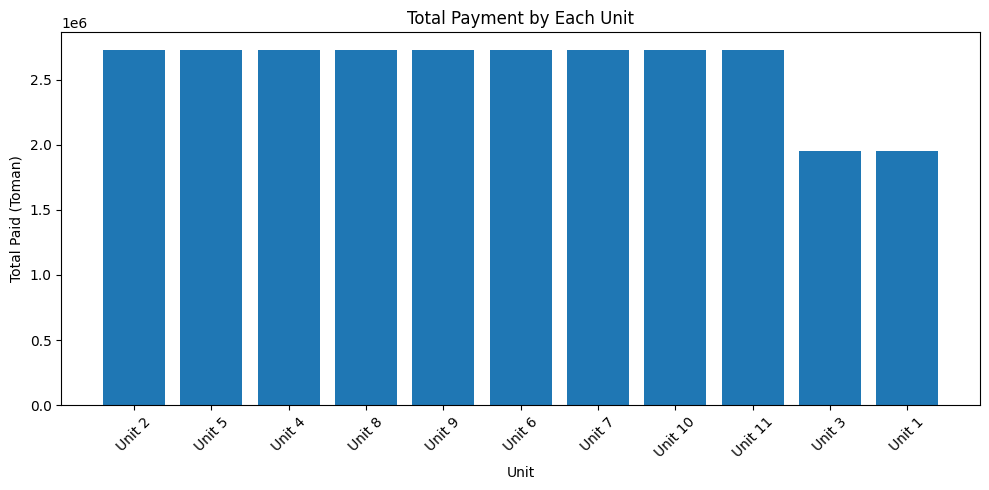

In [35]:
# 1️⃣ Bar Chart — Total Paid by Each Unit
plt.figure(figsize=(10, 5))
unit_totals_df_sorted = unit_totals_df.sort_values("Total Paid (Toman)", ascending=False)
plt.bar(unit_totals_df_sorted["Unit"], unit_totals_df_sorted["Total Paid (Toman)"])
plt.title("Total Payment by Each Unit")
plt.xlabel("Unit")
plt.ylabel("Total Paid (Toman)")
plt.xticks(rotation=45)
plt.tight_layout()


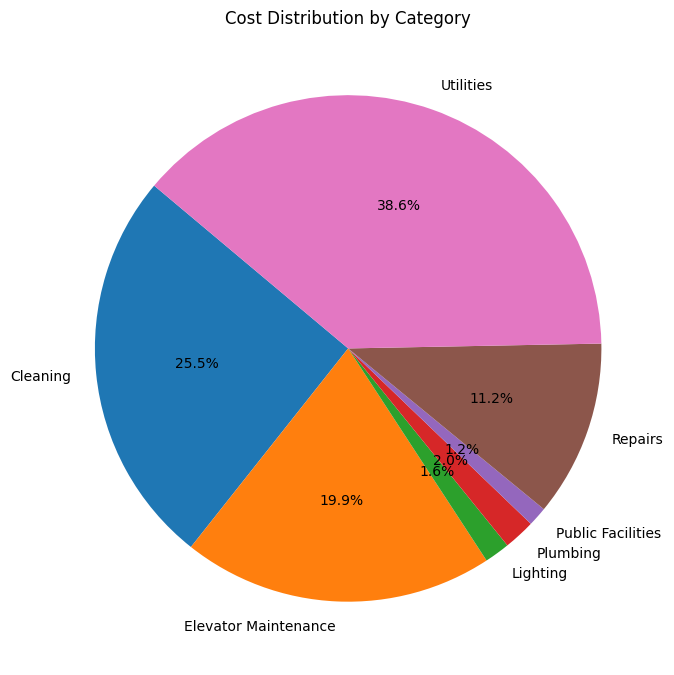

In [36]:
# 2️⃣ Pie Chart — Cost Distribution by Category
plt.figure(figsize=(7, 7))
plt.pie(category_summary["Total Amount (Toman)"], 
        labels=category_summary["Category"], 
        autopct="%1.1f%%", 
        startangle=140)
plt.title("Cost Distribution by Category")
plt.tight_layout()

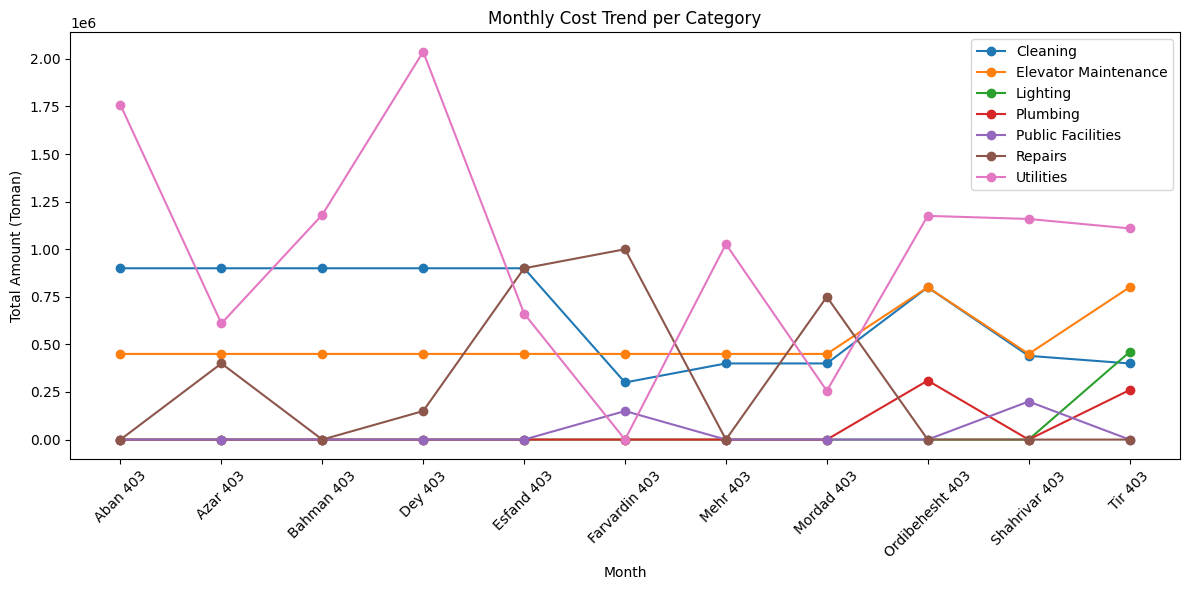

In [37]:
# 3️⃣ Line Chart — Monthly Cost Trend per Category
plt.figure(figsize=(12, 6))
monthly_cost_trends = pivot_category_month.set_index("Cost Category")
for category in monthly_cost_trends.index:
    plt.plot(monthly_cost_trends.columns, monthly_cost_trends.loc[category], 
             label=category, marker='o')
plt.title("Monthly Cost Trend per Category")
plt.xlabel("Month")
plt.ylabel("Total Amount (Toman)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

<Figure size 1200x600 with 0 Axes>

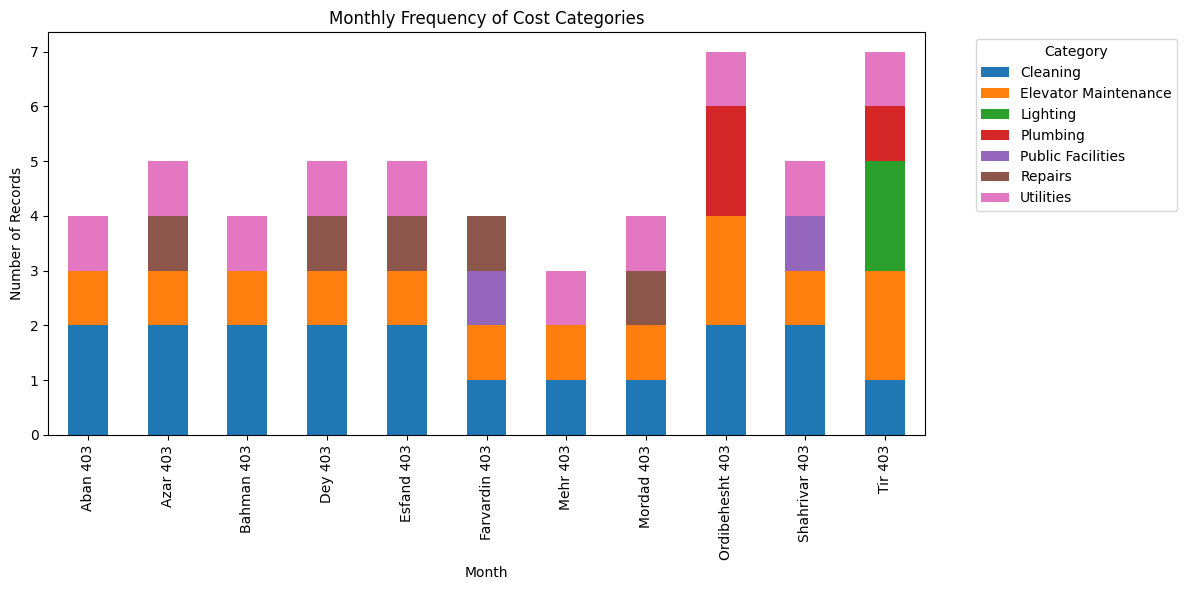

In [38]:
# 4️⃣ Stacked Bar Chart — Frequency of Each Cost Category Per Month
plt.figure(figsize=(12, 6))
pivot_count_plot = pivot_count.set_index("Cost Category").T
pivot_count_plot.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("Monthly Frequency of Cost Categories")
plt.xlabel("Month")
plt.ylabel("Number of Records")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()